In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys

!git clone -b recovery3 https://github.com/wjteng/LBC-IoT-Key-Recovery.git

sys.path.insert(0,'/content/LBC-IoT-Key-Recovery')

import numpy as np
from os import urandom
import lbciot as cipher
import pandas as pd
import train_nets as tn

rounds = 5;
epoch = 40;
diff1 = 0x0400;
diff2 = 0x0000;

name = str(diff1)+"_"+str(diff2)+"_r="+str(rounds)+"_epoch="+str(epoch);

model, h =tn.train_distinguisher(epoch,(diff1,diff2),num_rounds=rounds,depth=10);

model.save('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name);

Mounted at /content/gdrive/
Cloning into 'LBC-IoT-Key-Recovery'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 115 (delta 61), reused 91 (delta 46), pack-reused 0
Receiving objects: 100% (115/115), 256.36 KiB | 18.31 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Epoch 1/40
200/200 [==============================] - 38s 108ms/step - loss: 0.2489 - acc: 0.5568 - val_loss: 0.2574 - val_acc: 0.5605 - lr: 0.0020
Epoch 2/40
200/200 [==============================] - 21s 104ms/step - loss: 0.1471 - acc: 0.8005 - val_loss: 0.1405 - val_acc: 0.8043 - lr: 0.0018
Epoch 3/40
200/200 [==============================] - 21s 105ms/step - loss: 0.0888 - acc: 0.8990 - val_loss: 0.1050 - val_acc: 0.8687 - lr: 0.0016
Epoch 4/40
200/200 [==============================] - 21s 106ms/step - loss: 0.0652 - acc: 0.9320 - val_loss: 0.0682 - val_acc: 0.9274 - lr: 0.0014
Epoch 5/40
200/200 [=============

Mounted at /content/gdrive/
Cloning into 'LBC-IoT-Key-Recovery'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 118 (delta 63), reused 91 (delta 46), pack-reused 0
Receiving objects: 100% (118/118), 258.60 KiB | 1.55 MiB/s, done.
Resolving deltas: 100% (63/63), done.
0
10000
20000
30000
40000
50000
60000


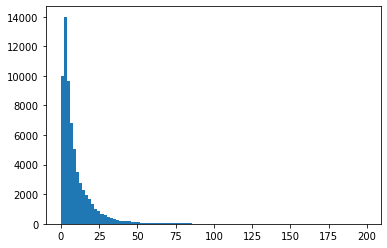

found max:25993
correct key:25993
[[25993   199]
 [17801   197]
 [25997   180]
 [17805   176]
 [50569   137]
 [58761   137]
 [26057   136]
 [17865   135]
 [26025   134]
 [26029   134]
 [29833   134]
 [17837   132]
 [29837   132]
 [30089   132]
 [17833   131]
 [19849   131]
 [21641   131]
 [21645   129]
 [25737   129]
 [25741   129]
 [30093   129]
 [21897   128]
 [24969   128]
 [17549   127]
 [19913   127]
 [30121   126]
 [16777   125]
 [17545   125]
 [21901   125]
 [28105   125]]
found max:17869
correct key:25993
[[17869   124]
 [26061   124]
 [28041   124]
 [21929   123]
 [25865   121]
 [58765   120]
 [17673   119]
 [50573   118]
 [19917   116]
 [ 9609   115]]


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys

!git clone -b recovery3 https://github.com/wjteng/LBC-IoT-Key-Recovery.git

sys.path.insert(0,'/content/LBC-IoT-Key-Recovery')

import numpy as np
from os import urandom
import lbciot as cipher
import pandas as pd
import train_nets as tn

n = 200; #number of plaintext pairs

rounds = 5;
epoch = 40;
diff1 = 0x0400;
diff2 = 0x0000;

key = np.frombuffer(urandom(10),dtype=np.uint16).reshape(5,-1);
keys = np.frombuffer(urandom(10*n),dtype=np.uint16).reshape(5,-1)*0+1 ;


for i in range(0,n):
  for j in range(0,5):
    keys[j][i]=key[j];


pt0l = np.frombuffer(urandom(2*n),dtype=np.uint16);
pt0r = np.frombuffer(urandom(2*n),dtype=np.uint16);

p0l = np.copy(pt0l); 
p0r = np.copy(pt0r);

p1l = p0l^diff1;
p1r = p0r^diff2;

ks = cipher.expand_key(keys, rounds + 1);

c0l,c0r = cipher.encrypt((p0l,p0r),ks);
c1l,c1r = cipher.encrypt((p1l,p1r),ks);



from tensorflow import keras

name = str(diff1)+"_"+str(diff2)+"_r="+str(rounds)+"_epoch="+str(epoch);
model = keras.models.load_model('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name);

allkeys = ks[rounds]*0;

count = np.zeros(2**16,dtype=int);

for i in range(0,2**16):
  if i%10000==0:
    print(i);
  c0l_dec1,c0r_dec1 = cipher.dec_one_round((c0l,c0r),allkeys);
  c1l_dec1,c1r_dec1 = cipher.dec_one_round((c1l,c1r),allkeys);
  X = cipher.convert_to_binary([c0l_dec1,c0r_dec1,c1l_dec1,c1r_dec1]);
  Z = model.predict(X,batch_size=10000);
  count[allkeys[0]] =  np.sum(Z>0.5);
  allkeys = allkeys + 1;

df = pd.DataFrame(count);
df.to_csv('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+'count_'+str(diff1)+'_'+str(diff2)+'.csv');

import matplotlib.pyplot as plt

plt.hist(count, bins=100)
plt.savefig('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name+'_counthist.png')
plt.show()


count[np.argmax(count)]
print('found max:'+str(np.argmax(count)))
print('correct key:'+str(ks[rounds][0]));
count[41855]
sorted_count = -np.sort(-count);
temp = count;
top = 30;
rank = np.zeros((top,2),dtype=int);
for i in range(0,top):
  max_index = np.argmax(temp);
  rank[i][0] = max_index;
  rank[i][1] = temp[max_index];
  temp[max_index]=-1;

print(rank);

  

